<a href="https://colab.research.google.com/github/Jwalitsolanki/Oil-and-Gas_ML/blob/master/Lithofacies_prediction_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.pipeline import Pipeline

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [ ]:
df['Well Name'].unique()

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

In [ ]:
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']


X = df[feature_names].values 
y = df['Facies'].values

well = df['Well Name'].values
depth = df['Depth'].values

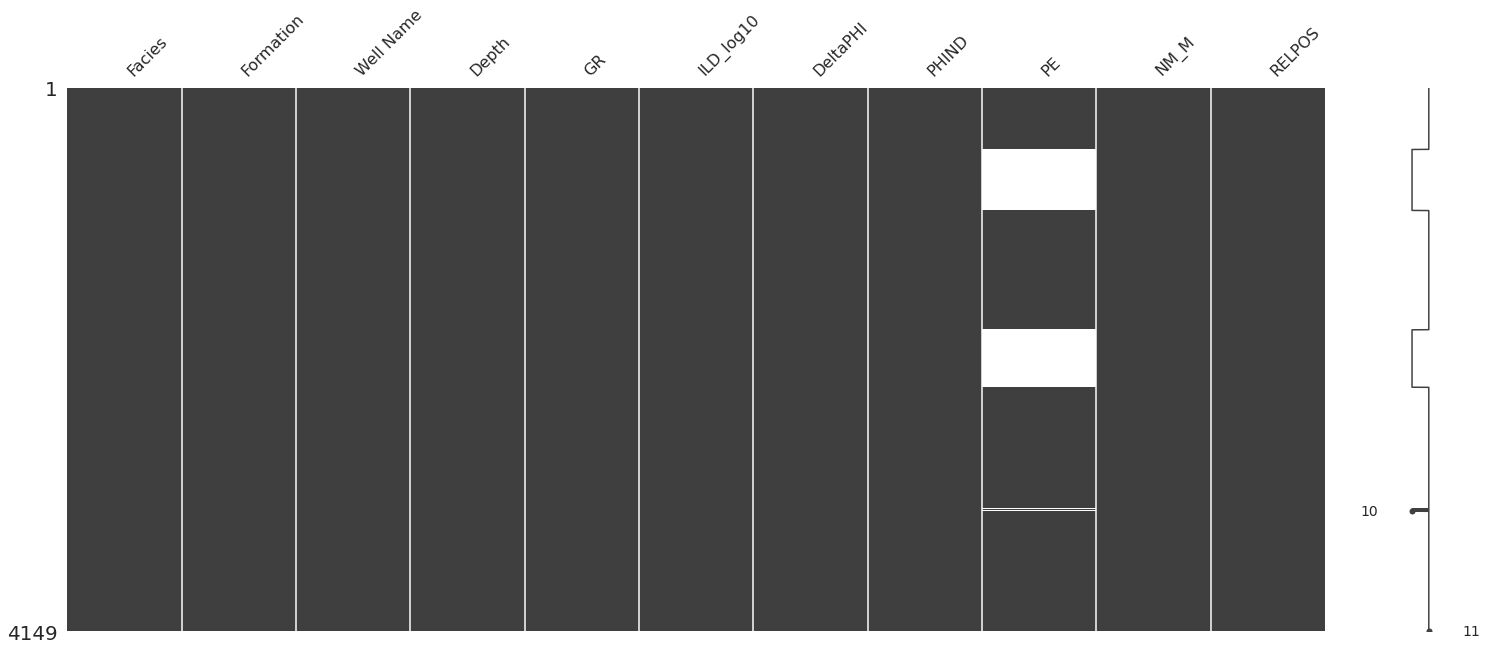

In [ ]:
import missingno
missingno.matrix(df)

In [ ]:
#Just a copy, incase it gets ugly!
df_1 = df.copy()

In [ ]:
blind = df_1[df_1['Well Name'] == 'SHANKLE']
training_data = df_1[df_1['Well Name'] != 'SHANKLE']
print(training_data.shape)

(3700, 11)


In [ ]:
facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [ ]:
def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_names), axis=1)
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Facies,3700.0,4.615676,2.475808,1.000000,2.00000,4.000000,7.0000,9.000
Depth,3700.0,2908.853378,139.010855,2573.500000,2818.50000,2939.000000,3015.1250,3138.000
GR,3700.0,64.873649,30.817166,10.149000,43.77825,64.817000,80.3225,361.150
ILD_log10,3700.0,0.663053,0.253863,-0.025949,0.50200,0.645613,0.8230,1.800
DeltaPHI,3700.0,4.651677,5.109006,-21.832000,1.80000,4.400000,7.6000,19.312
PHIND,3700.0,12.892826,6.796219,0.550000,8.35000,11.857500,15.7500,84.400
PE,2783.0,3.805693,0.894118,0.200000,3.20000,3.600000,4.4000,8.094
NM_M,3700.0,1.540000,0.498465,1.000000,1.00000,2.000000,2.0000,2.000
RELPOS,3700.0,0.524125,0.287147,0.000000,0.27800,0.531000,0.7720,1.000


In [ ]:
import operator

def outlier_removal(df, op, limit, replace):
    temp_name = df.name
    print('Before outlier removal for',df.name)
    print(df.name,'Min',min(df[df.notnull()]))
    print(df.name,'Max',max(df[df.notnull()]))
    outliers = [x for x in df if op(x,limit)]
    print('Number of',df.name,'outliers:',len(outliers),'\n')
    
    df = np.where((op(df,limit)), replace, df)
    df = pd.Series(df)
    print('After outlier removal for',temp_name)
    print(temp_name,'Min',min(df[df.notnull()]))
    print(temp_name,'Max',max(df[df.notnull()]))
    
    return df

In [ ]:
df['GR'] = outlier_removal(df['GR'], operator.gt, 200, 200)
df['ILD_log10'] = outlier_removal(df['ILD_log10'], operator.le, 0, np.nan)

Before outlier removal for GR
GR Min 10.149
GR Max 361.15
Number of GR outliers: 27 

After outlier removal for GR
GR Min 10.149
GR Max 200.0
Before outlier removal for ILD_log10
ILD_log10 Min -0.025949097
ILD_log10 Max 1.8
Number of ILD_log10 outliers: 12 

After outlier removal for ILD_log10
ILD_log10 Min 0.0021660620000000003
ILD_log10 Max 1.8


In [ ]:
df.shape

(4149, 11)

In [ ]:
X = df[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
y = df['Facies']

In [ ]:
from sklearn.model_selection import LeavePGroupsOut

lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=df['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (df['Well Name'][split['train']].unique()))
    print('    validation: %s' % (df['Well Name'][split['val']].unique()))

Split 0
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['ALEXANDER D' 'CHURCHMAN BIBLE']
Split 1
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN' 'Recruit F9' 'NEWBY'
 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'CROSS H CATTLE']
Split 2
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'KIMZEY A']
Split 3
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'NOLAN']
Split 4
    training:   ['SHRIMPLIN' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'SHANKLE']
Split 5
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['CROSS H CATTLE' 'CHURCHMAN BIBLE'

In [ ]:
X.fillna(0, inplace=True)

In [ ]:
X_1 = split['train']
X_2 = split['val']
print(X_1.shape)
print(X_2.shape)

(3229,)
(920,)


In [ ]:
training_data['GR'] = outlier_removal(training_data['GR'], operator.gt, 200, 200)
training_data['ILD_log10'] = outlier_removal(training_data['ILD_log10'], operator.le, 0, np.nan)

Before outlier removal for GR
GR Min 10.149
GR Max 361.15
Number of GR outliers: 23 

After outlier removal for GR
GR Min 10.149
GR Max 200.0
Before outlier removal for ILD_log10
ILD_log10 Min -0.025949097
ILD_log10 Max 1.8
Number of ILD_log10 outliers: 12 

After outlier removal for ILD_log10
ILD_log10 Min 0.0021660620000000003
ILD_log10 Max 1.8


In [ ]:
X_11 = training_data[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
y_11 = training_data['Facies']

In [ ]:
X_11.fillna(0, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_11, y_11, test_size=0.2, random_state=42)

In [ ]:
print(X_test.shape)
print(X_train.shape)

(740, 5)
(2960, 5)


In [ ]:
X_111 = blind[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
y_111 = blind['Facies']

In [ ]:
blind.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.8MB/s 


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='Dr. Marathe sir short course on ML',
    project_name='Kansas westfield DL_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_111, y_111))

Trial 5 Complete [00h 01m 22s]
val_accuracy: 0.24573124945163727

Best val_accuracy So Far: 0.4454343020915985
Total elapsed time: 00h 03m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in Dr. Marathe sir short course on ML/Kansas westfield DL_1
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 352
units_1: 160
learning_rate: 0.001
units_2: 416
units_3: 288
units_4: 448
units_5: 192
units_6: 160
units_7: 288
units_8: 384
units_9: 416
units_10: 448
units_11: 448
units_12: 256
units_13: 320
units_14: 320
units_15: 192
Score: 0.4454343020915985
Trial summary
Hyperparameters:
num_layers: 3
units_0: 448
units_1: 352
learning_rate: 0.01
units_2: 32
Score: 0.44394951065381366
Trial summary
Hyperparameters:
num_layers: 10
units_0: 96
units_1: 256
learning_rate: 0.01
units_2: 512
units_3: 224
units_4: 320
units_5: 384
units_6: 416
units_7: 448
units_8: 448
units_9: 256
units_10: 416
units_11: 224
units_12: 320
units_13: 128
units_14: 160
units_15: 416
Score: 0.3697104553381602
Trial summary
Hyperparameters:
num_layers: 16
units_0: 192
units_1: 224
learning_rate: 0.0001
units_2: 4